# COVID-19 Data Analyses using New York Times Data

Note: The most up-to-date version of this notebook can be found in GitHub repository [bmc/covid19][].

The primary data source for this notebook is 
[COVID-19 data from The New York Times](https://github.com/nytimes/covid-19-data).

For additional data sources used, see [the README](https://github.com/bmc/covid19/blob/master/README.md)
in [bmc/covid19].

## Approach

This notebook loads the New York Times COVID-19 CSV files into [Pandas](https://pandas.pydata.org/) DataFrames. It
then manipulates, queries, and plots data via the DataFrames.

[**I don't want to look at code. Take me to the first graph!**](#United-States-as-a-whole)


[bmc/covid19]: https://github.com/bmc/covid19/

## Imports and constants

In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import os
import sys
import re
import math
from pprint import pprint
from collections import namedtuple
from lib.common import *

print(f"Using Python {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print(f"Using matplotlib {matplotlib.__version__}")
print(f"Using Pandas {pd.__version__}")

Using Python 3.8.4
Using matplotlib 3.2.2
Using Pandas 1.0.5


In [2]:
NYTIMES_DIR_PATH = 'data/nytimes/covid-19-data'
SOURCE = "New York Times"
US_DATA = os.path.join(NYTIMES_DIR_PATH, 'us.csv')
US_STATE_DATA = os.path.join(NYTIMES_DIR_PATH, 'us-states.csv')
US_COUNTY_DATA = os.path.join(NYTIMES_DIR_PATH, 'us-counties.csv')

In [3]:
os.makedirs(IMAGES_PATH, exist_ok=True)
today = datetime.now().date()

## State population data

In [4]:
populations = load_united_states_population_data()
print(f"{populations['United States']:,}")

334,351,157


## Read the New York Times data

In [5]:
def read_nyt_us_data(path):
    """
    Reads the New York Times COVID-19 US-wide CSV file
    into a Pandas DataFrame, converting the date field
    to the appropriate type. Removes any records prior
    to April 12. Also adds a month_day string column.
    """
    df = pd.read_csv(path).rename(columns={
            'date':   COL_DATE,
            'state':  COL_REGION,
            'cases':  COL_CASES,
            'deaths': COL_DEATHS
        })
    df = df[[COL_DATE, COL_REGION, COL_CASES, COL_DEATHS]]

    df[COL_DATE] = pd.to_datetime(df[COL_DATE], format='%Y-%m-%d')

    df[COL_HOSPITALIZATIONS] = 0
    df[COL_RECOVERIES] = 0
    df[COL_TESTS] = 0

    for col in (COL_DEATHS, COL_CASES):
        df[col] = df[col].fillna(0)

    make_month_day_column(df)
    cutoff = datetime(year=2020, month=4, day=12, hour=0, minute=0, second=0)
    return df.loc[df[COL_DATE] >= cutoff]

In [6]:
def read_nyt_us_county_data(path):
    """
    Reads the New York Times COVID-19 US county CSV file
    into a Pandas DataFrame, converting the date field
    to the appropriate type. Removes any records prior
    to April 12. Also adds a month_day string column.
    """
    df = pd.read_csv(path)[['date', 'county', 'state', 'cases', 'deaths']]
    df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
    df.cases.fillna(0)
    df.deaths.fillna(0)
    make_month_day_column(df)
    cutoff = datetime(year=2020, month=4, day=12, hour=0, minute=0, second=0)
    return df.loc[df[COL_DATE] >= cutoff]

In [7]:
df_states = read_nyt_us_data(US_STATE_DATA)
print(f"Read data for {len(df_states.date.unique())} days.")
start_date = df_states.date.min()
end_date = df_states.date.max()
print(f"Starting date: {datestr(start_date.date(), include_year=True)}")
print(f"Ending date: {datestr(end_date.date(), include_year=True)}")

Read data for 103 days.
Starting date: 04/12/2020
Ending date: 07/23/2020


In [8]:
df_states

,date,region,cases,deaths,hospitalizations,recoveries,tests,month_day
2214,2020-04-12,Alabama,3583,93,0,0,0,04/12
2215,2020-04-12,Alaska,270,6,0,0,0,04/12
2216,2020-04-12,Arizona,3539,117,0,0,0,04/12
2217,2020-04-12,Arkansas,1280,27,0,0,0,04/12
2218,2020-04-12,California,23323,676,0,0,0,04/12
...,...,...,...,...,...,...,...,...
7874,2020-07-23,Virginia,81237,2054,0,0,0,07/23
7875,2020-07-23,Washington,52255,1548,0,0,0,07/23
7876,2020-07-23,West Virginia,5550,103,0,0,0,07/23
7877,2020-07-23,Wisconsin,49751,887,0,0,0,07/23


In [9]:
df_counties = read_nyt_us_county_data(US_COUNTY_DATA)
print(f"Read data for {len(df_counties.date.unique())} days.")
print(f"Starting date: {datestr(df_counties.date.min(), include_year=True)}")
print(f"Ending date: {datestr(df_counties.date.max(), include_year=True)}")

Read data for 103 days.
Starting date: 04/12/2020
Ending date: 07/23/2020


In [10]:
df_counties

,date,county,state,cases,deaths,month_day
51087,2020-04-12,Autauga,Alabama,19,1,04/12
51088,2020-04-12,Baldwin,Alabama,71,1,04/12
51089,2020-04-12,Barbour,Alabama,10,0,04/12
51090,2020-04-12,Bibb,Alabama,16,0,04/12
51091,2020-04-12,Blount,Alabama,13,0,04/12
...,...,...,...,...,...,...
363487,2020-07-23,Sweetwater,Wyoming,206,2,07/23
363488,2020-07-23,Teton,Wyoming,254,1,07/23
363489,2020-07-23,Uinta,Wyoming,227,0,07/23
363490,2020-07-23,Washakie,Wyoming,44,5,07/23


## Deaths and cases in a single region

### United States

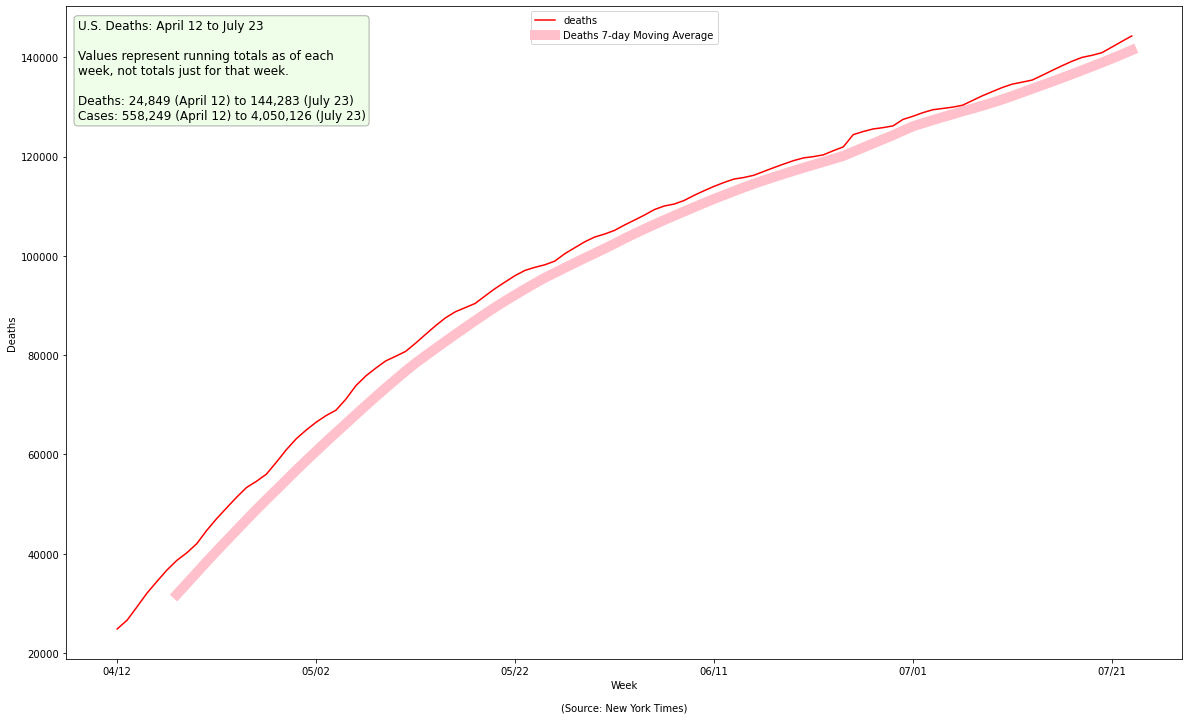

In [11]:
plot_stats_by_date(df_states, SOURCE, metrics={MetricType.DEATHS}, moving_average=True,
                   image_file='nyt-us-deaths.png', textbox_heading="U.S. Deaths")

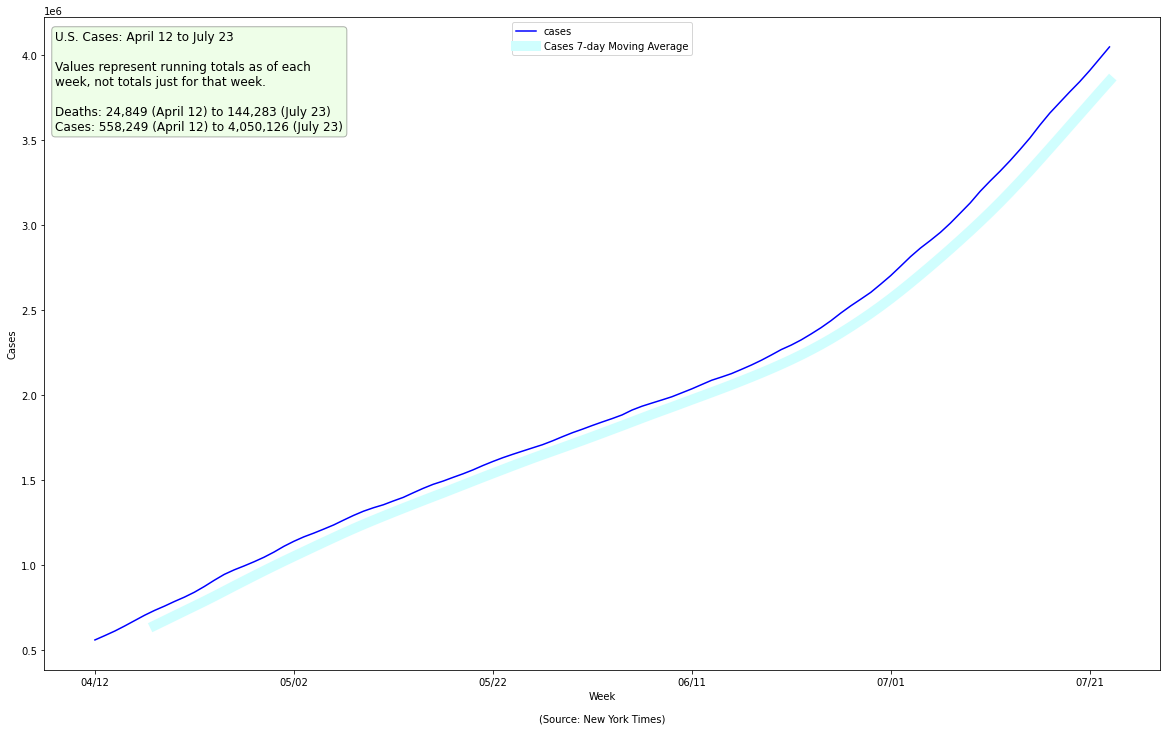

In [12]:
plot_stats_by_date(df_states, SOURCE, metrics={MetricType.CASES}, moving_average=True,
                   image_file='nyt-us-cases.png', textbox_heading="U.S. Cases")

#### Just the past week

In [13]:
week_delta = timedelta(days=6)
six_days_prior = end_date - week_delta
last_week_start = date_to_datetime(six_days_prior)
last_week_end = date_to_datetime(end_date, hour=23, minute=59, second=59)

df_past_week = df_states.loc[(df_states.date >= last_week_start) & (df_states.date <= last_week_end)]

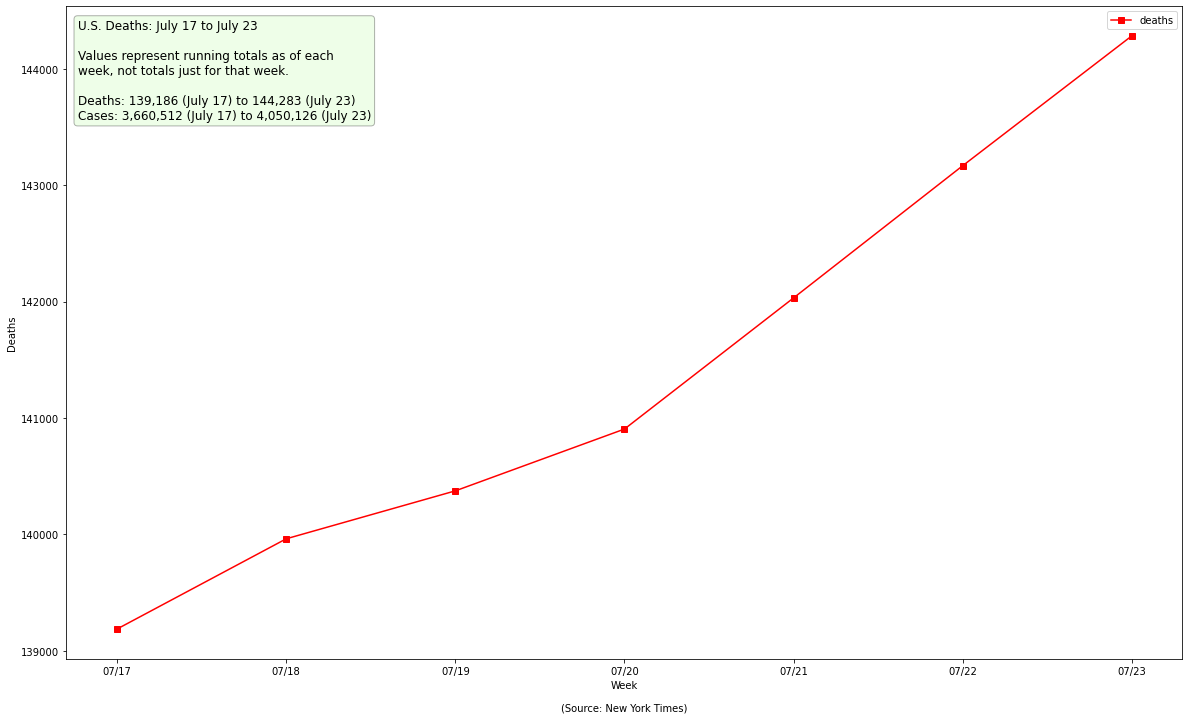

In [14]:
plot_stats_by_date(df_past_week, SOURCE, metrics={MetricType.DEATHS}, marker='s', 
                   textbox_heading="U.S. Deaths", image_file='nyt-us-deaths-past-week.png')

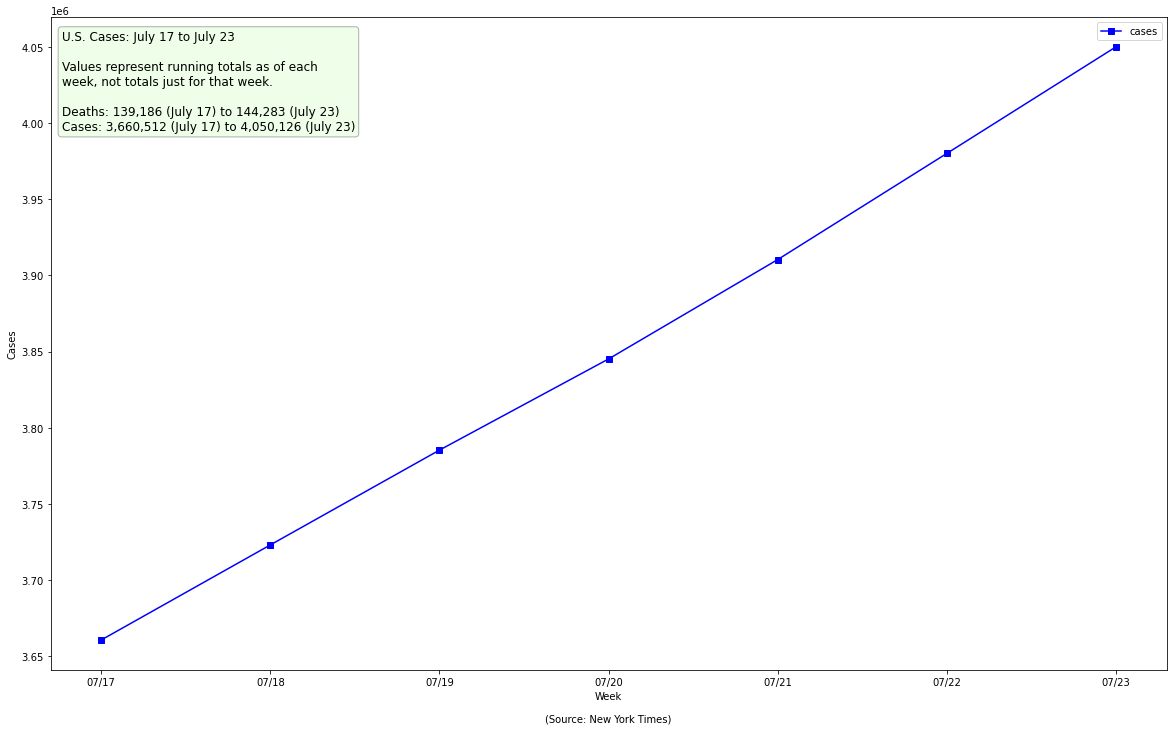

In [15]:
plot_stats_by_date(df_past_week, SOURCE, metrics={MetricType.CASES}, marker='s', 
                   textbox_heading="U.S. Cases", image_file='nyt-us-cases-past-week.png')

#### Deaths vs. Cases

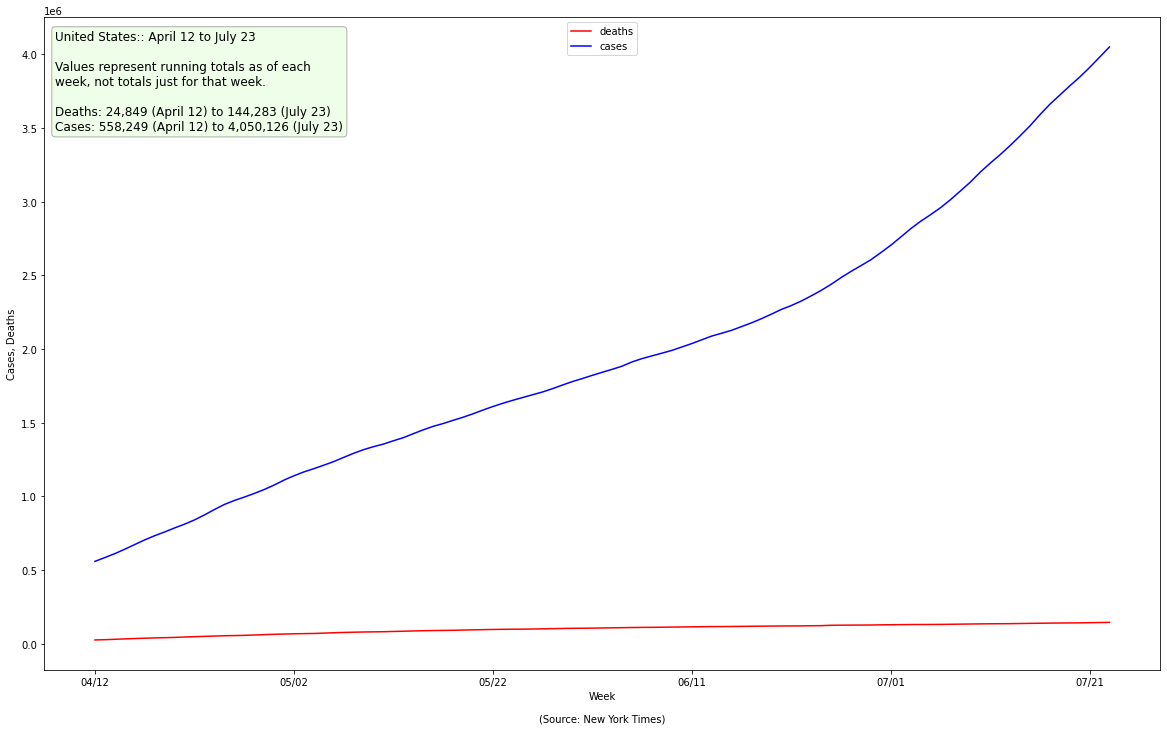

In [16]:
plot_stats_by_date(df_states, SOURCE, metrics={MetricType.DEATHS, MetricType.CASES}, textbox_heading="United States:",
                   image_file="nyt-us-deaths-and-cases.png")

### Individual States

#### Pennsylvania

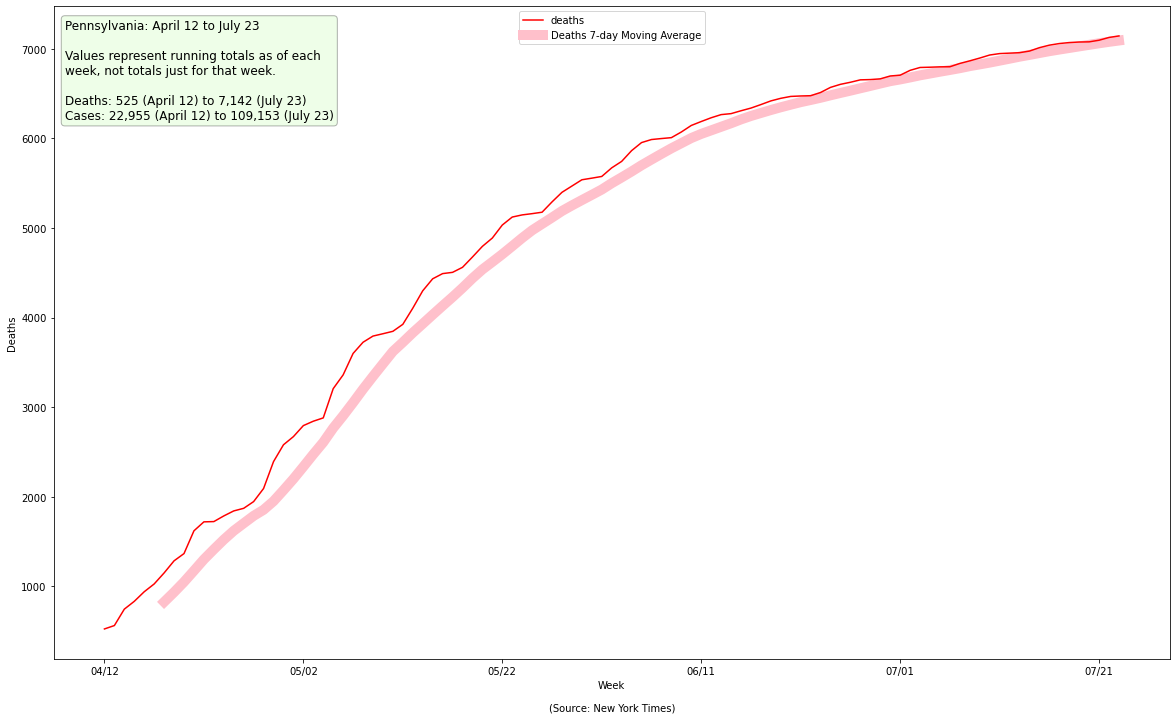

In [17]:
plot_state(df_states, SOURCE, 'Pennsylvania', moving_average=True,
           image_file='nyt-pa-deaths.png', metrics={MetricType.DEATHS})

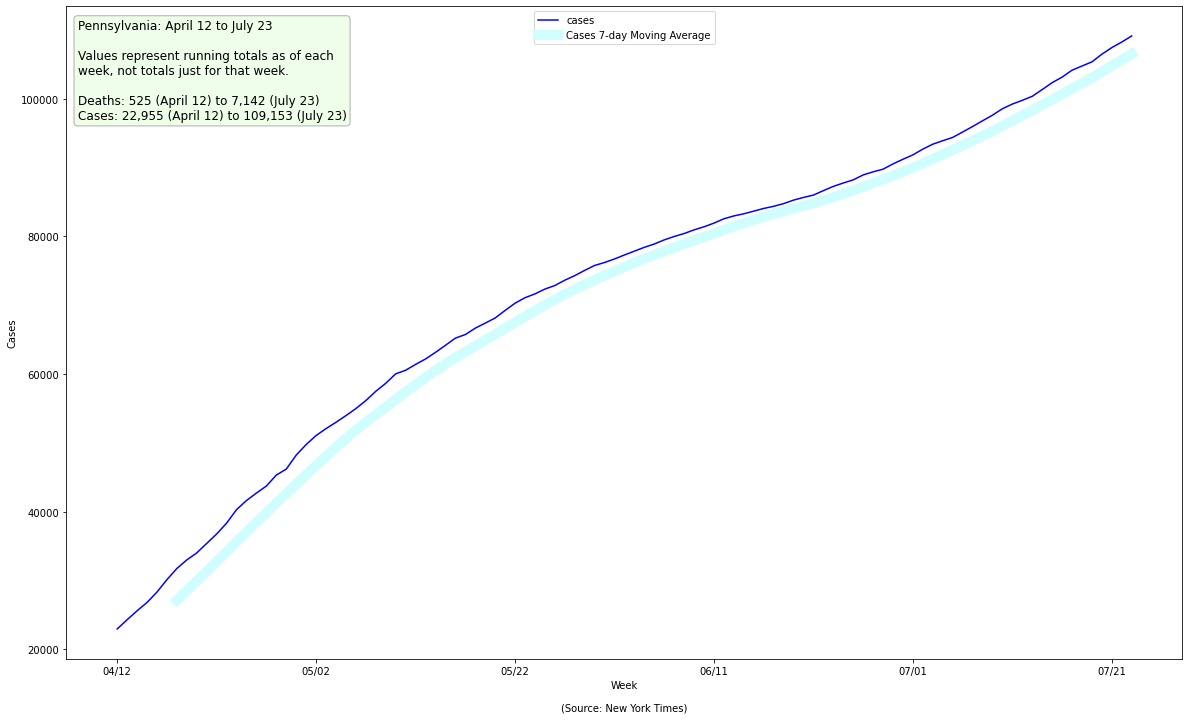

In [18]:
plot_state(df_states, SOURCE, 'Pennsylvania', moving_average=True,
           image_file='nyt-pa-cases.png', metrics={MetricType.CASES})

#### New York

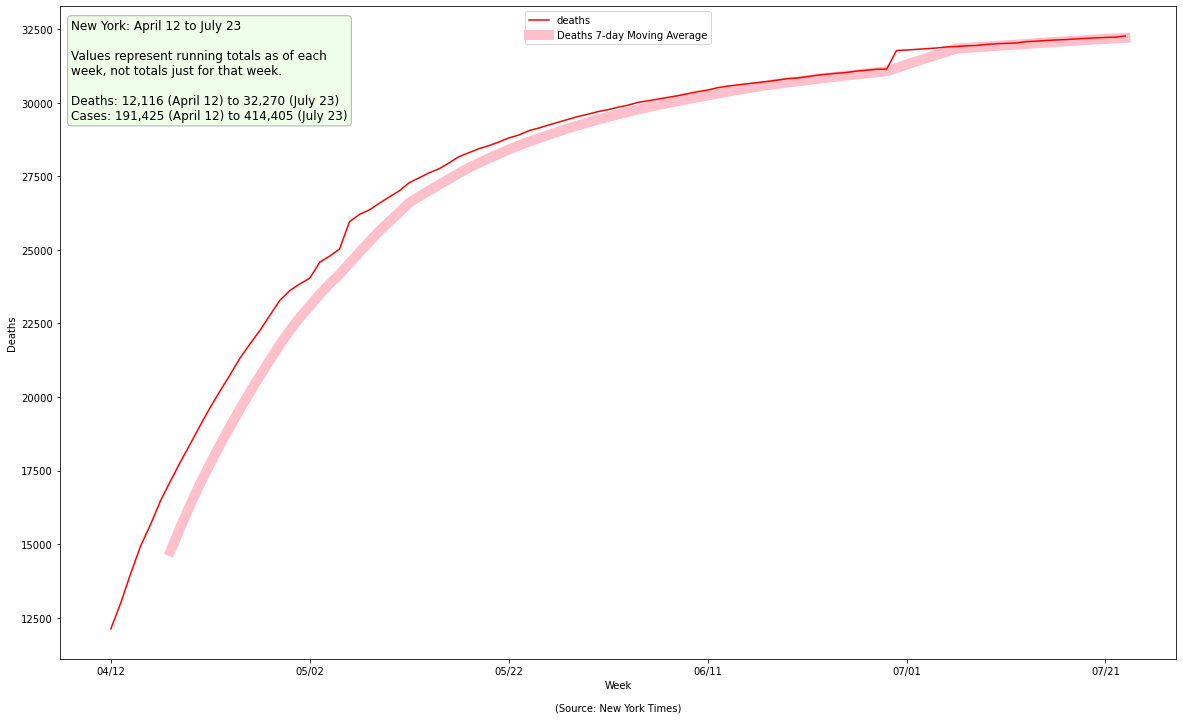

In [19]:
plot_state(df_states, SOURCE, 'New York', moving_average=True,
           image_file='nyt-ny-deaths.png', metrics={MetricType.DEATHS})

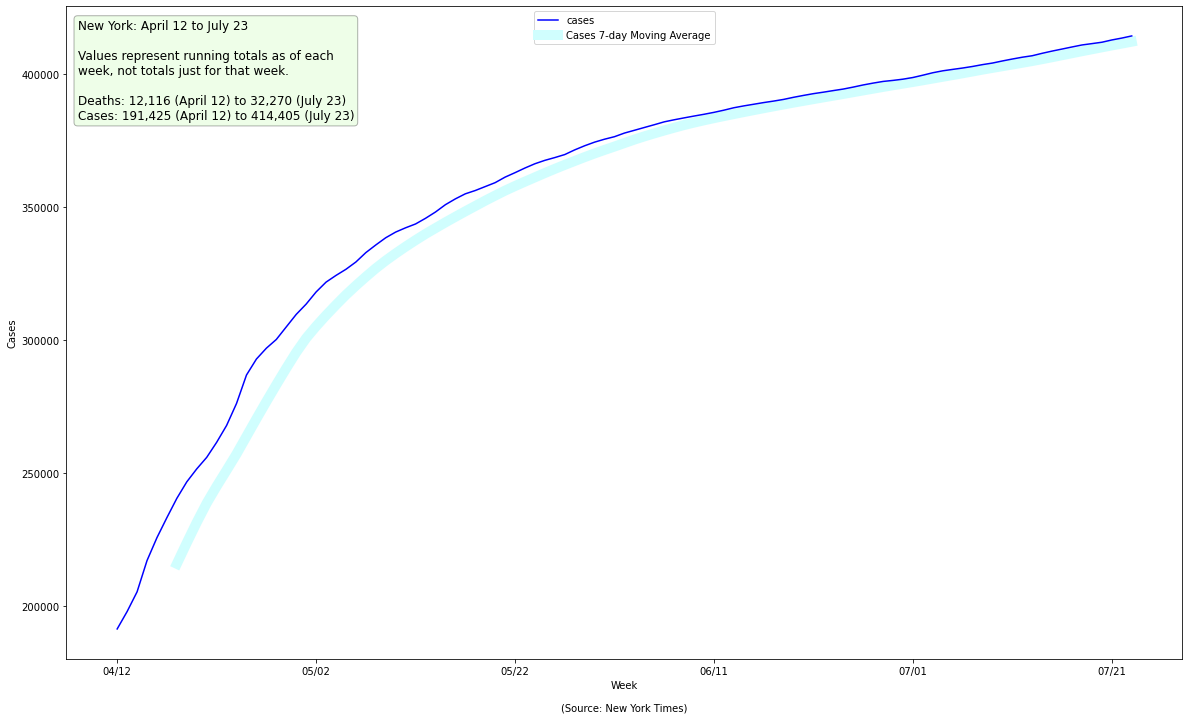

In [20]:
plot_state(df_states, SOURCE, 'New York', moving_average=True,
           image_file='nyt-ny-deaths.png', metrics={MetricType.CASES})

#### Washington

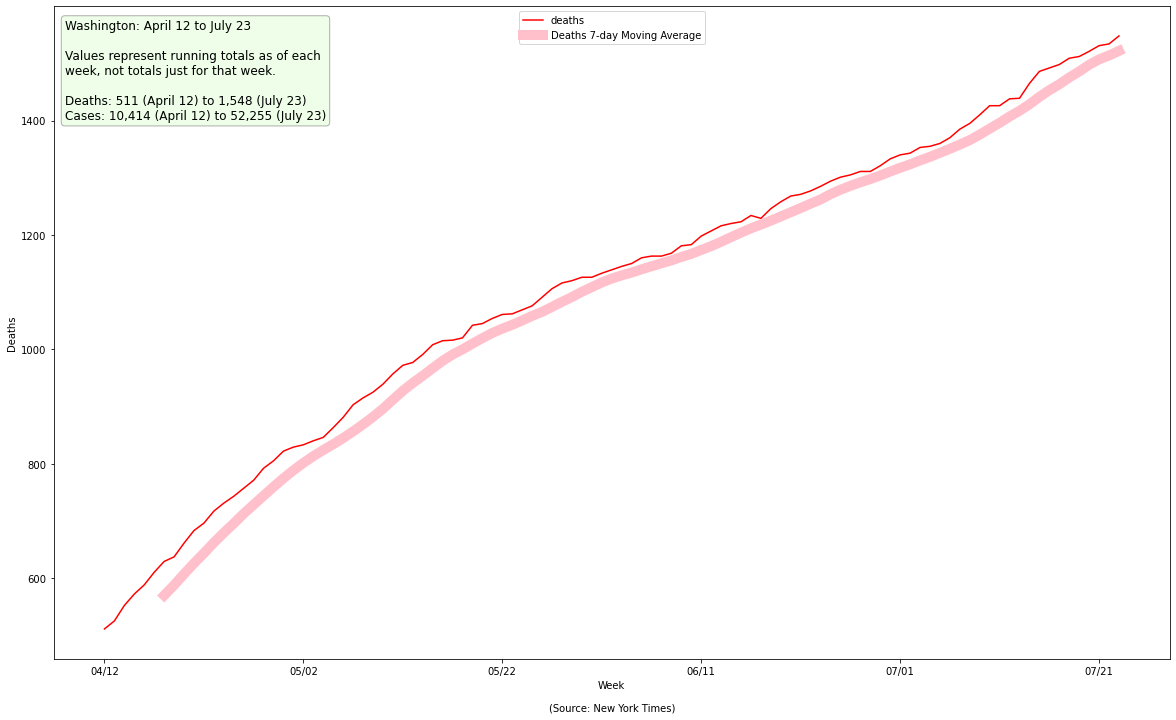

In [21]:
plot_state(df_states, SOURCE, 'Washington', moving_average=True,
           image_file='nyt-wa-deaths.png', metrics={MetricType.DEATHS})

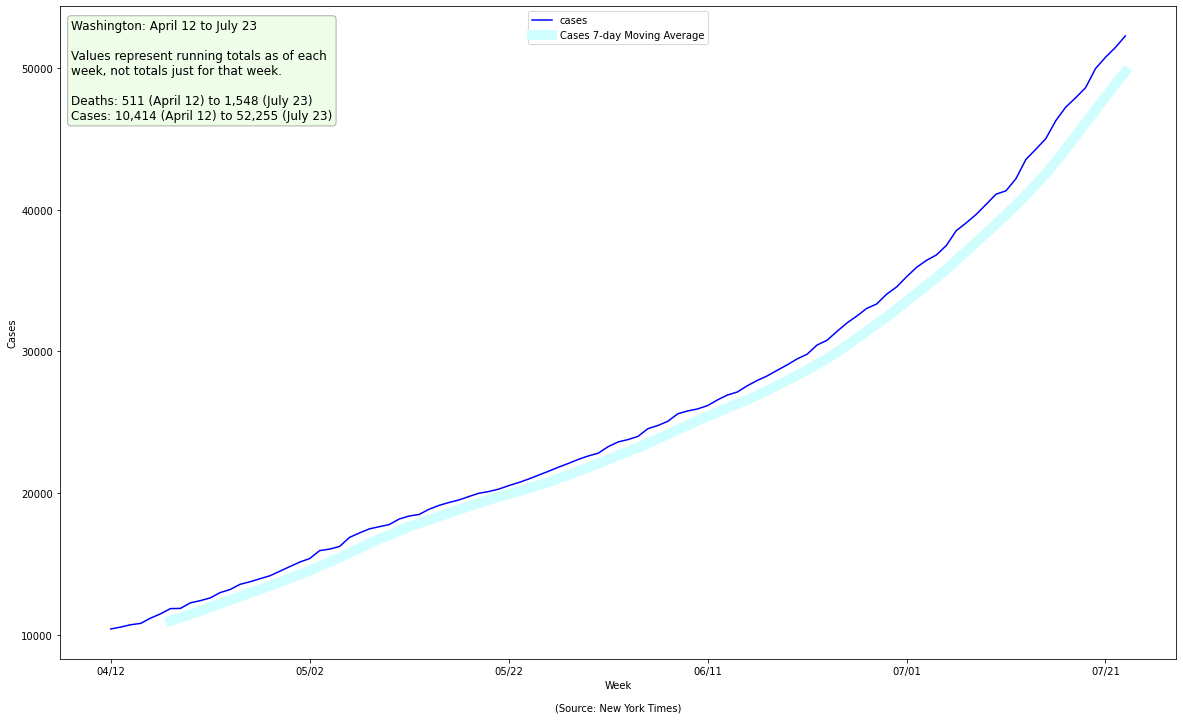

In [22]:
plot_state(df_states, SOURCE, 'Washington', moving_average=True,
           image_file='nyt-wa-cases.png', metrics={MetricType.CASES})

#### Delaware

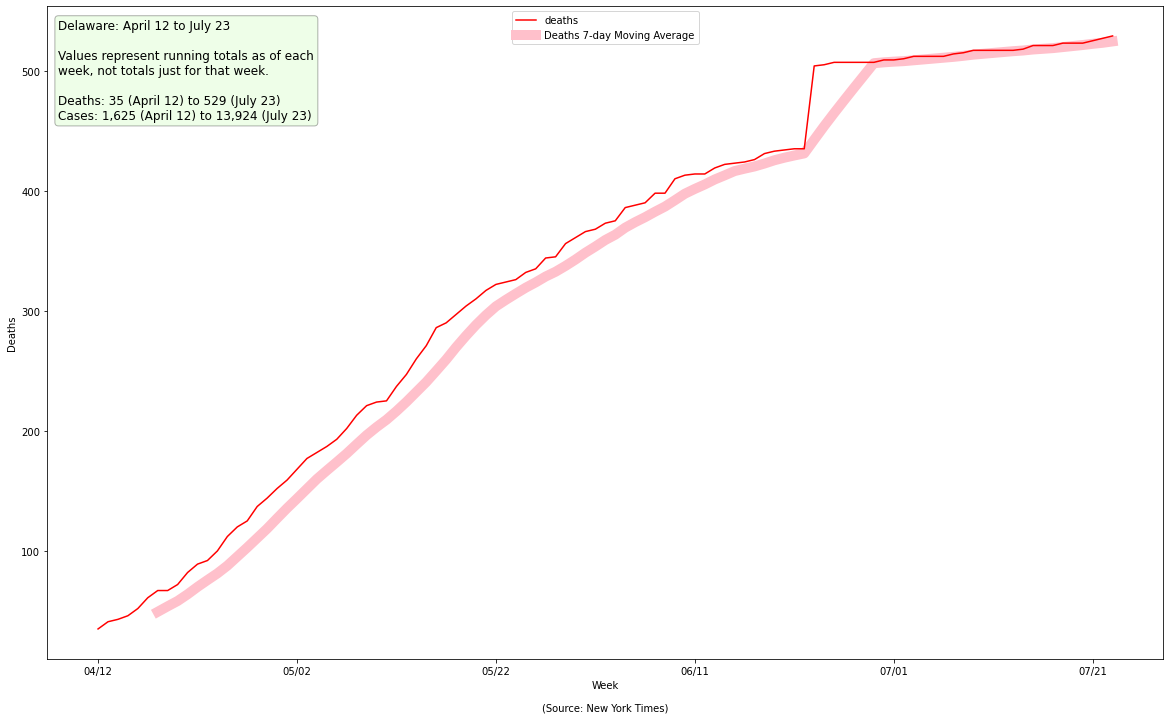

In [23]:
plot_state(df_states, SOURCE, 'Delaware', moving_average=True,
           image_file='nyt-de-deaths.png', metrics={MetricType.DEATHS})

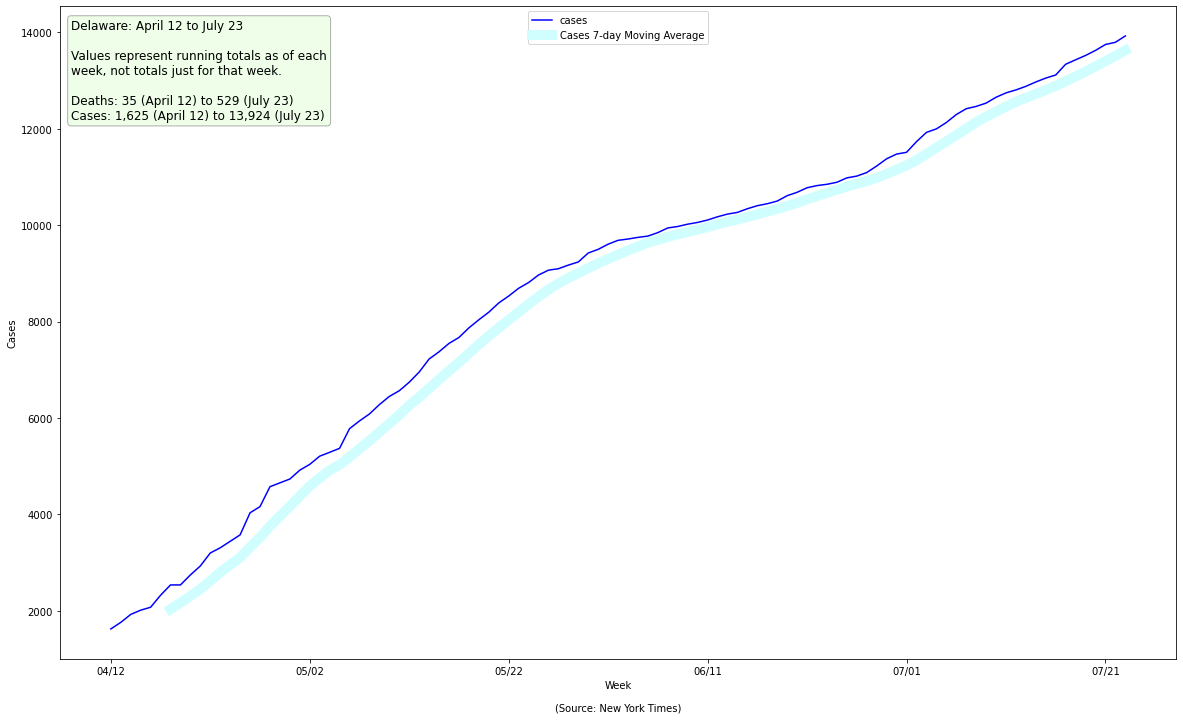

In [24]:
plot_state(df_states, SOURCE, 'Delaware', moving_average=True,
           image_file='nyt-de-cases.png', metrics={MetricType.CASES})

#### Texas

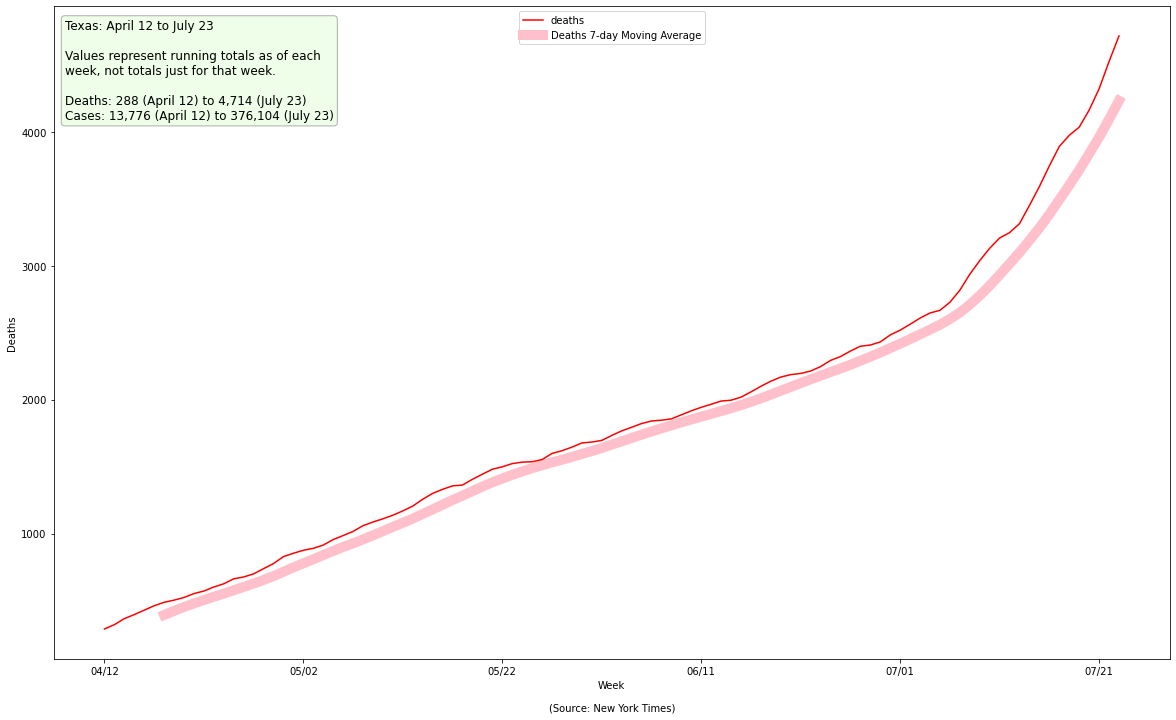

In [25]:
plot_state(df_states, SOURCE, 'Texas', moving_average=True,
           image_file='nyt-tx-deaths.png', metrics={MetricType.DEATHS})

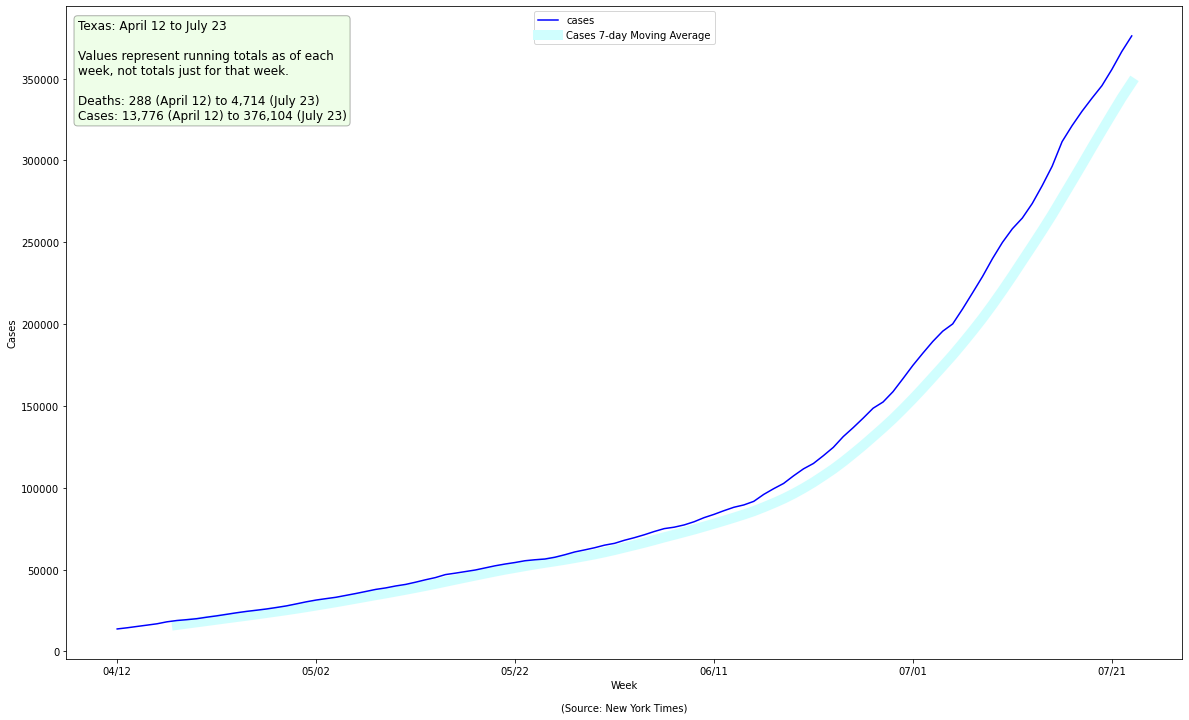

In [26]:
plot_state(df_states, SOURCE, 'Texas', moving_average=True,
           image_file='nyt-tx-cases.png', metrics={MetricType.CASES})

#### Georgia

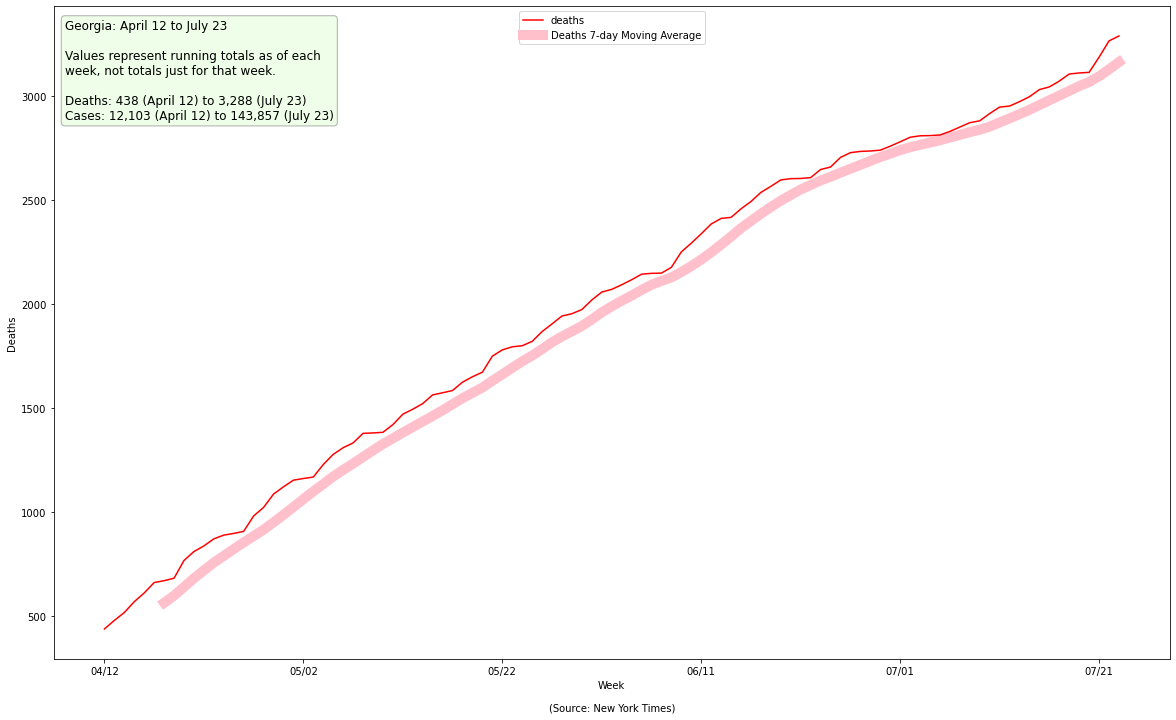

In [27]:
plot_state(df_states, SOURCE, 'Georgia', moving_average=True,
           image_file='nyt-ga-deaths.png', metrics={MetricType.DEATHS})

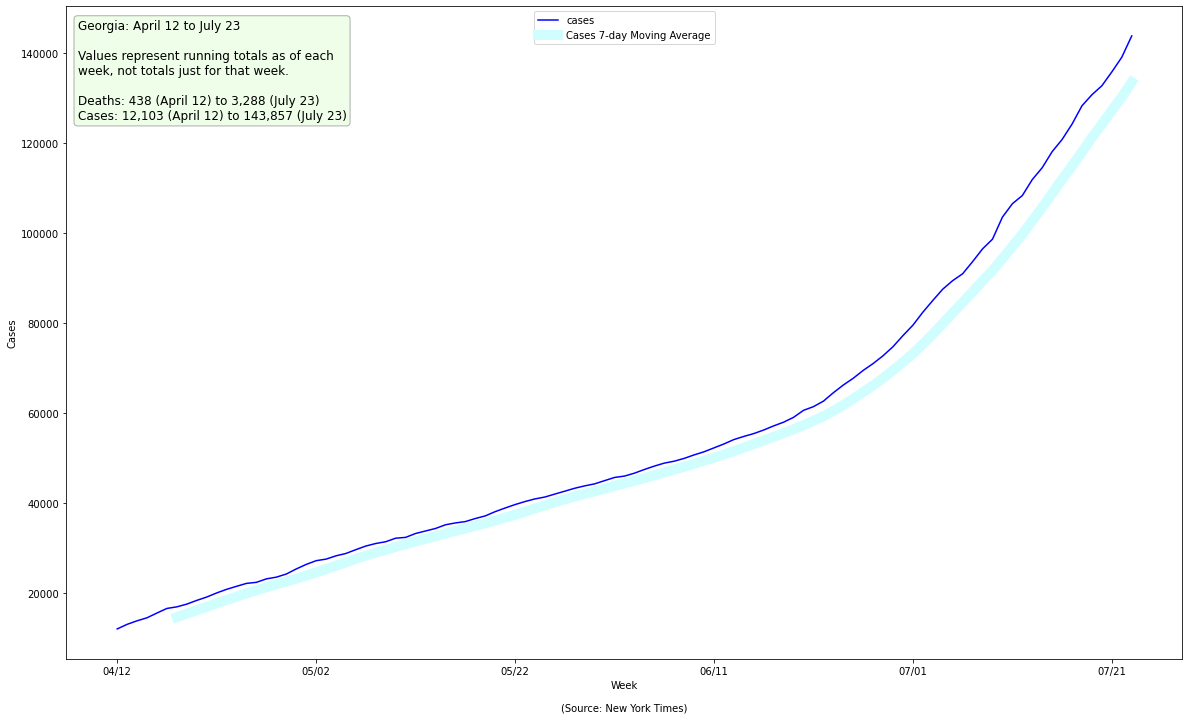

In [28]:
plot_state(df_states, SOURCE, 'Georgia', moving_average=True,
           image_file='nyt-ga-cases.png', metrics={MetricType.CASES})

#### Mississippi

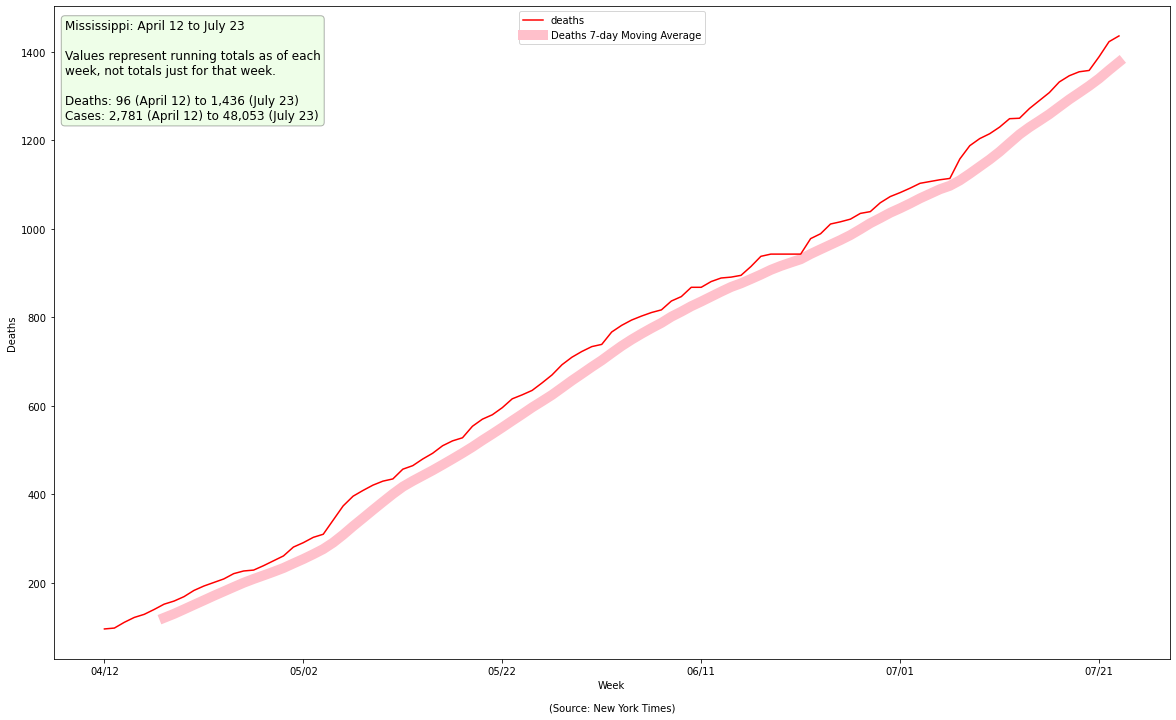

In [29]:
plot_state(df_states, SOURCE, 'Mississippi', moving_average=True,
           image_file='nyt-ms-deaths.png', metrics={MetricType.DEATHS})

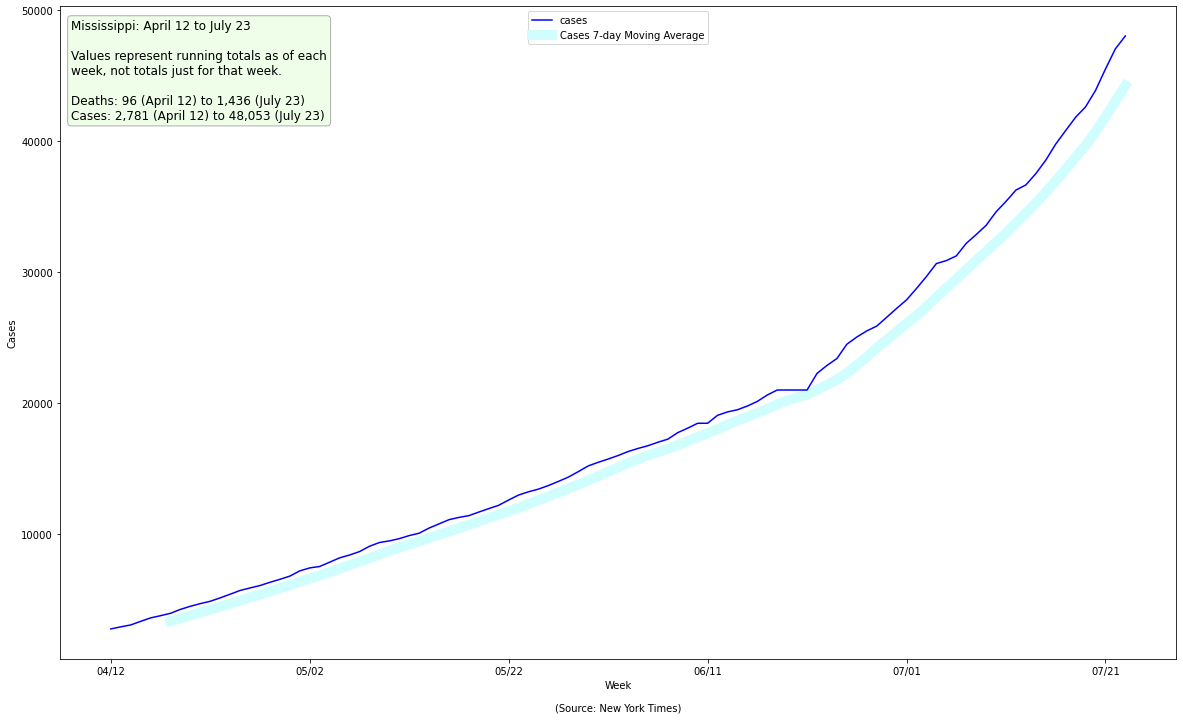

In [30]:
plot_state(df_states, SOURCE, 'Mississippi', moving_average=True,
           image_file='nyt-ms-cases.png', metrics={MetricType.CASES})

#### Arizona

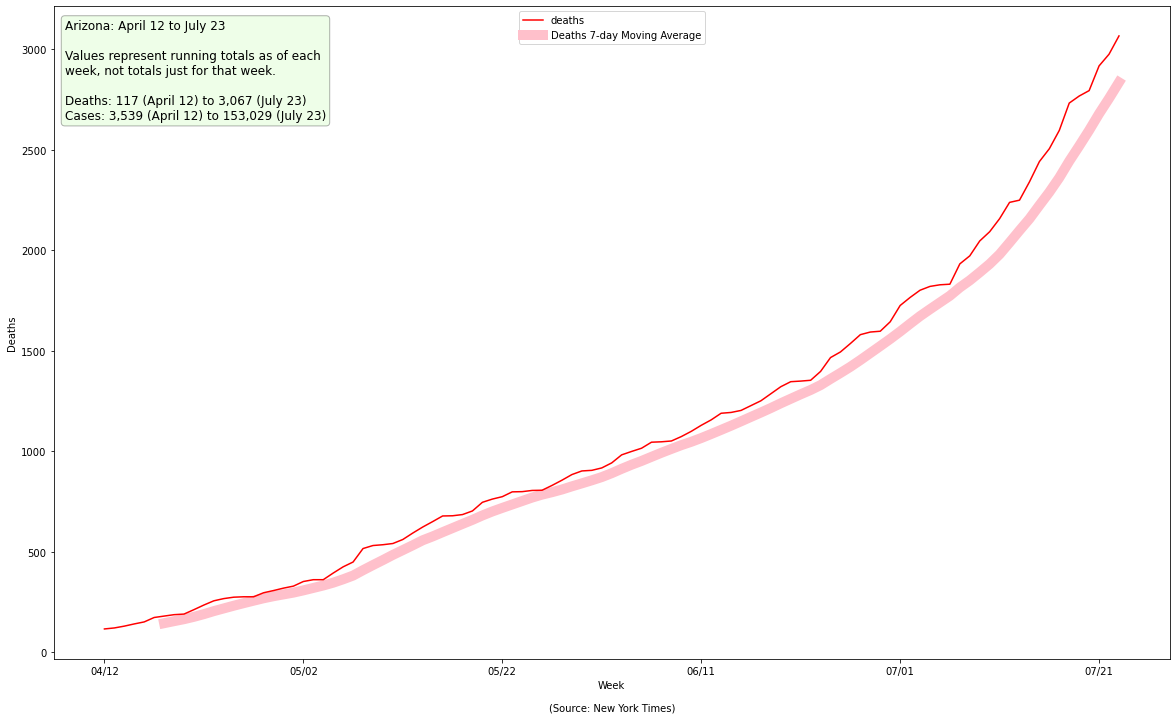

In [31]:
plot_state(df_states, SOURCE, 'Arizona', moving_average=True,
           image_file='nyt-az-deaths.png', metrics={MetricType.DEATHS})

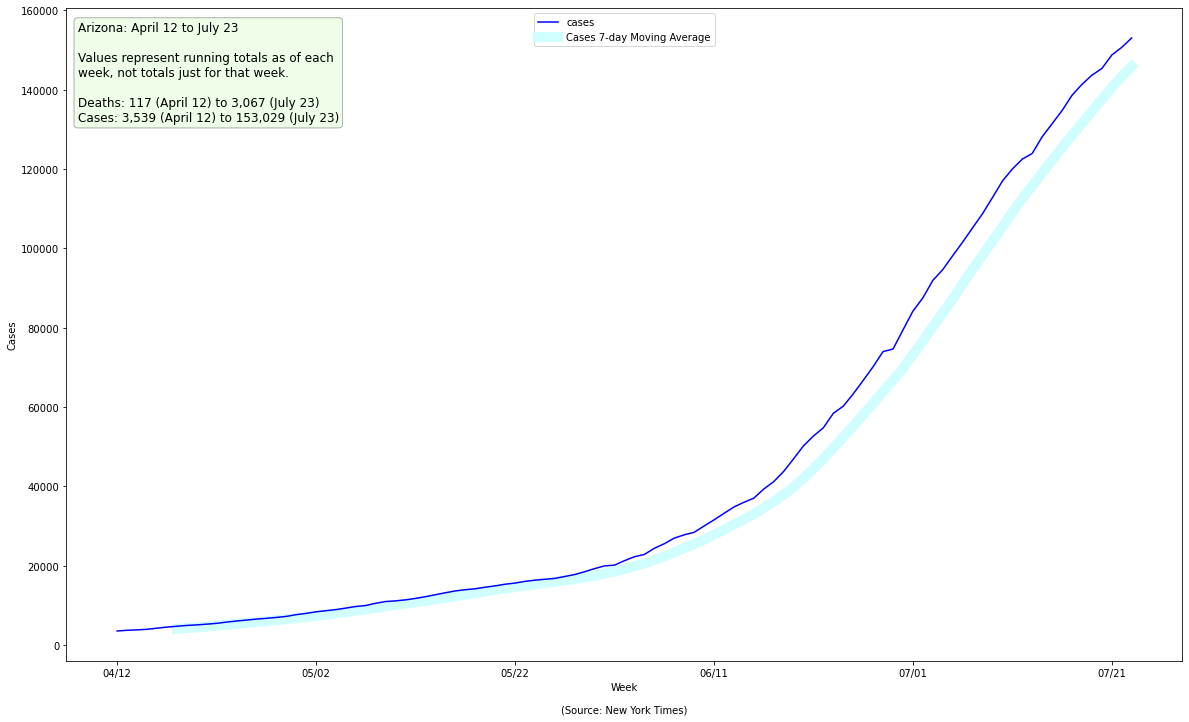

In [32]:
plot_state(df_states, SOURCE, 'Arizona', moving_average=True,
           image_file='nyt-az-cases.png', metrics={MetricType.CASES})

## Multistate

### Northeast states

Data from some of the states that were hardest hit early on.

In [33]:
ne_states = ('Connecticut', 'New York', 'New Jersey', 'Pennsylvania', 'Delaware', 'Ohio')

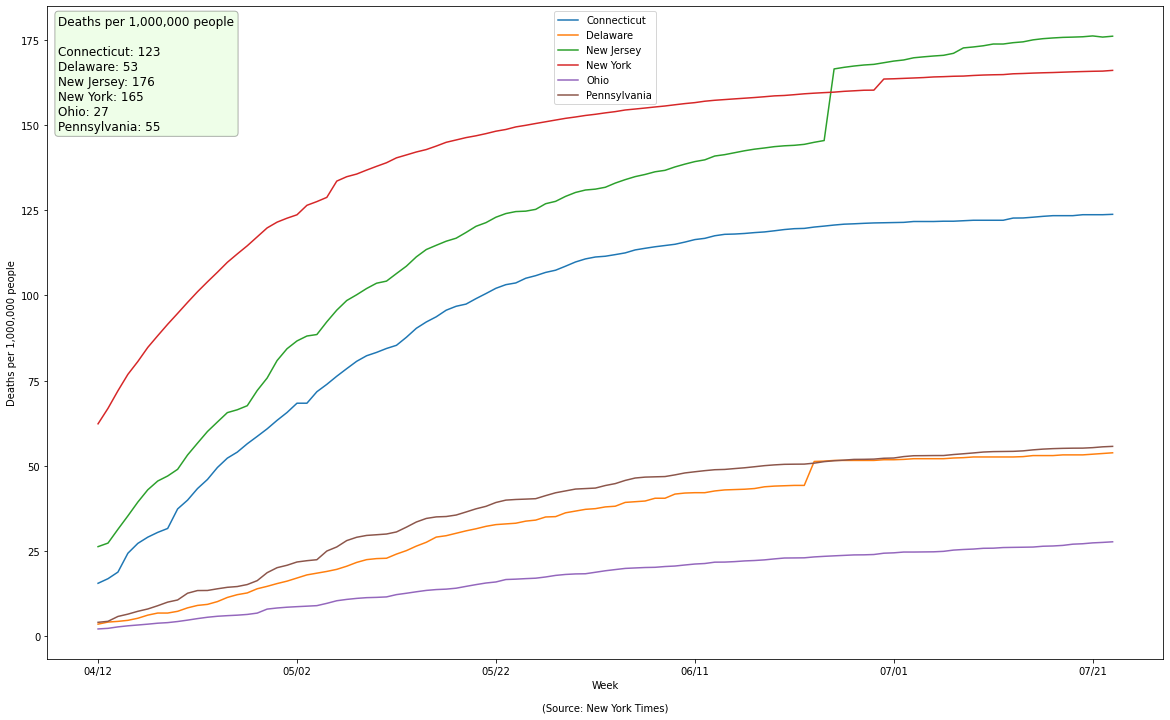

In [34]:
plot_states(df_states, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='upper center', image_file='nyt-ne-states-deaths-per-capita.png')

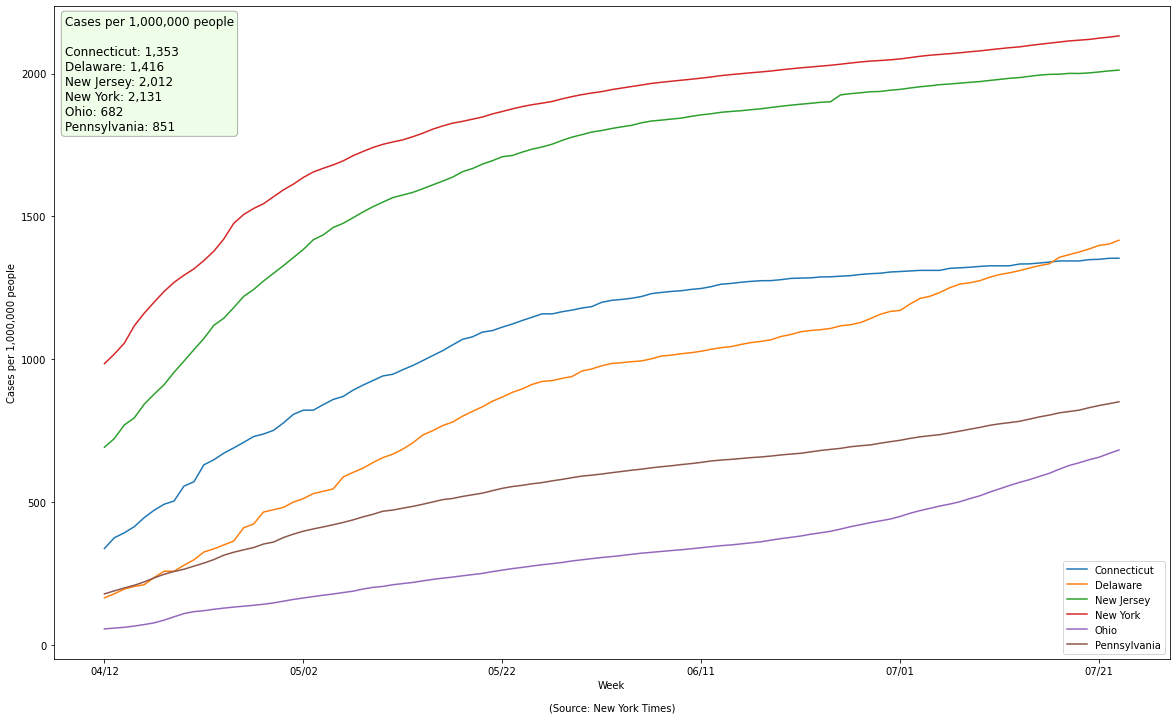

In [35]:
plot_states(df_states, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.CASES,
            legend_loc='lower right', image_file='nyt-ne-states-cases-per-capita.png')

### South and southwestern states

Data from some of the states hard hit in mid-2020.

In [36]:
s_sw_states = ('Arizona', 'Texas', 'Oklahoma', 'South Carolina', 'Utah', 'California', 'Florida')

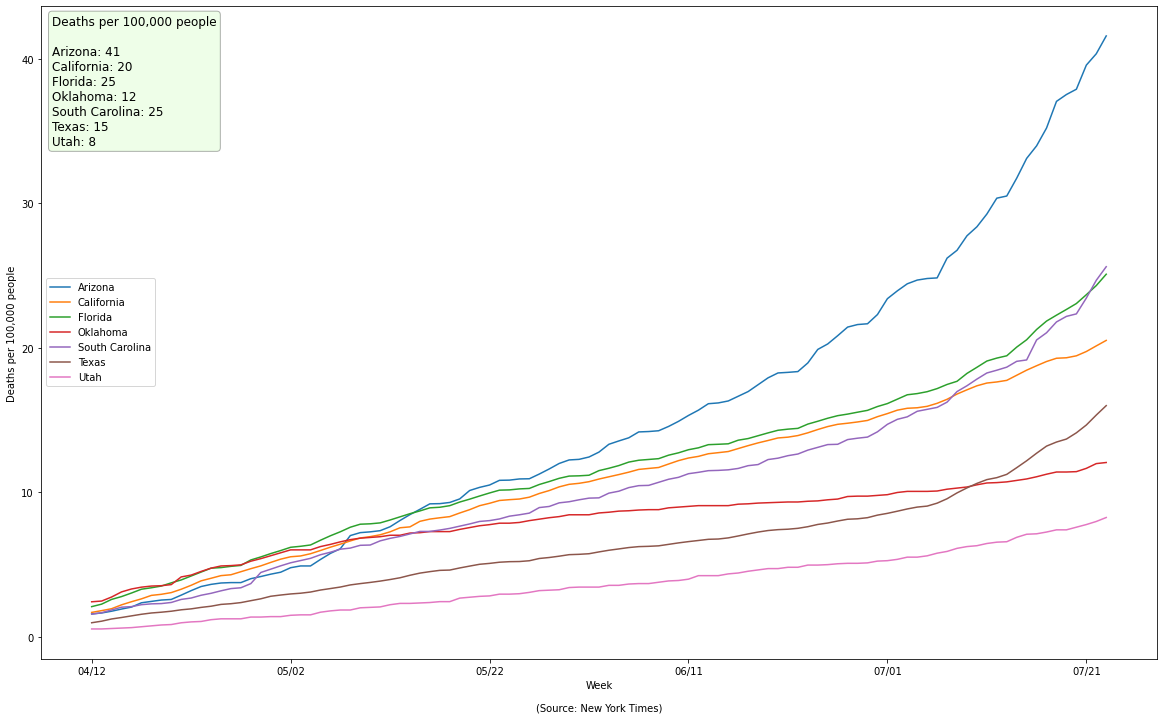

In [37]:
plot_states(df_states, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='center left', image_file='nyt-s-sw-states-deaths-per-capita.png')

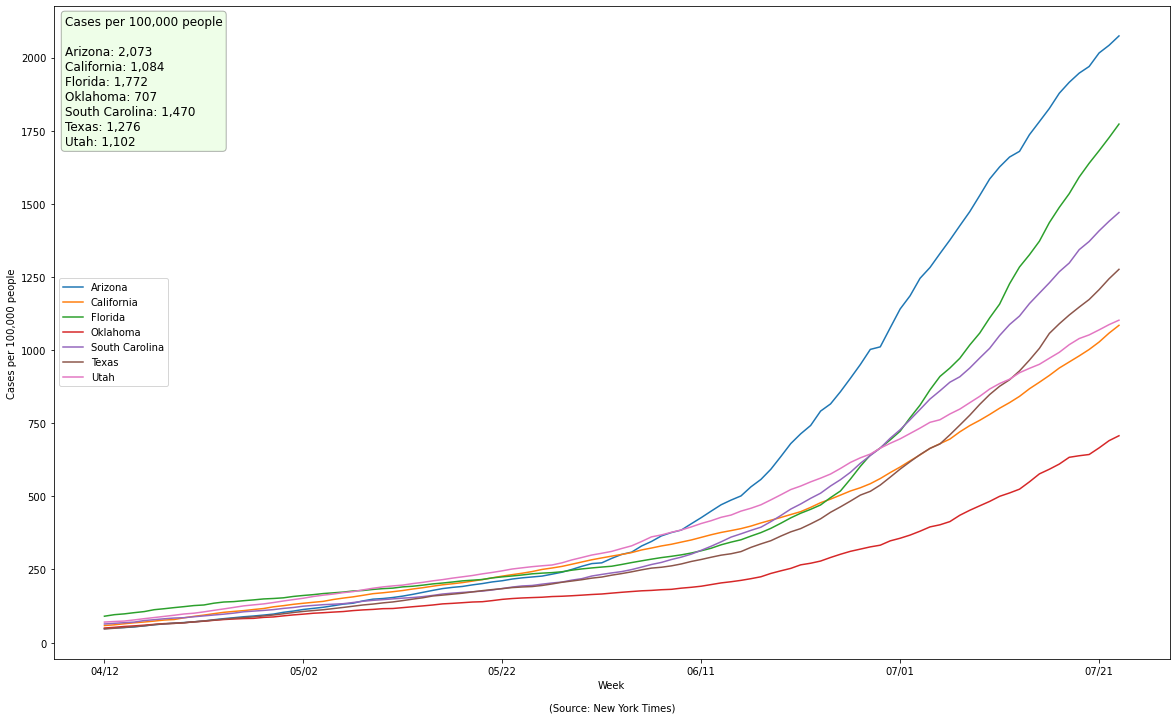

In [38]:
plot_states(df_states, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='nyt-s-sw-states-cases-per-capita.png')

How are some of these states doing, compared to Pennsylvania (my home state)?

In [39]:
s_sw_plus_pa = s_sw_states + ('Pennsylvania',)

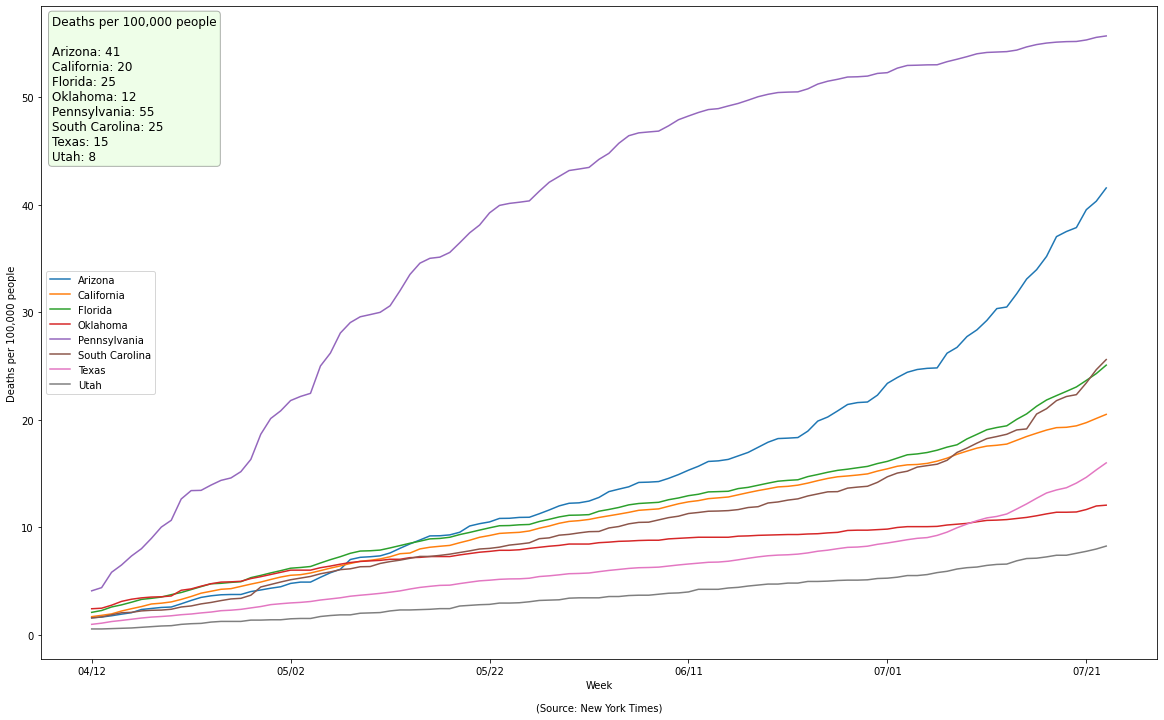

In [40]:
plot_states(df_states, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='center left', image_file='nyt-s-sw-states-with-pa-deaths-per-capita.png')

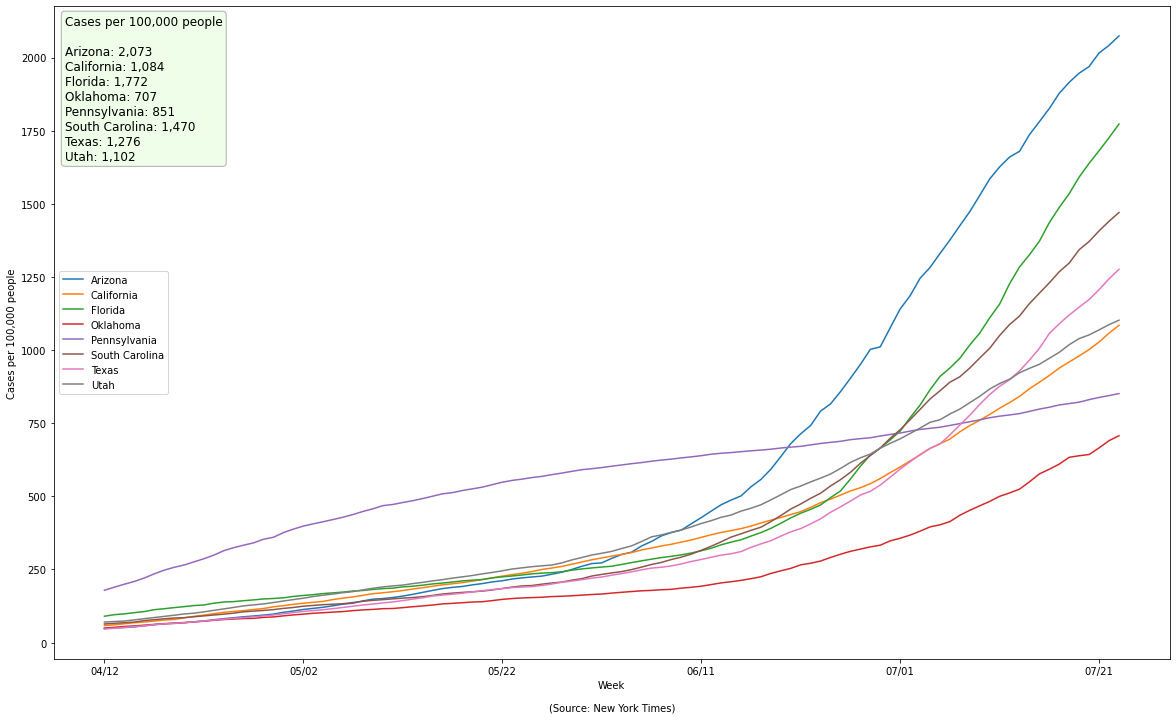

In [41]:
plot_states(df_states, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='nyt-s-sw-states-with-pa-cases-per-capita.png')

## Per-capita rates for all states

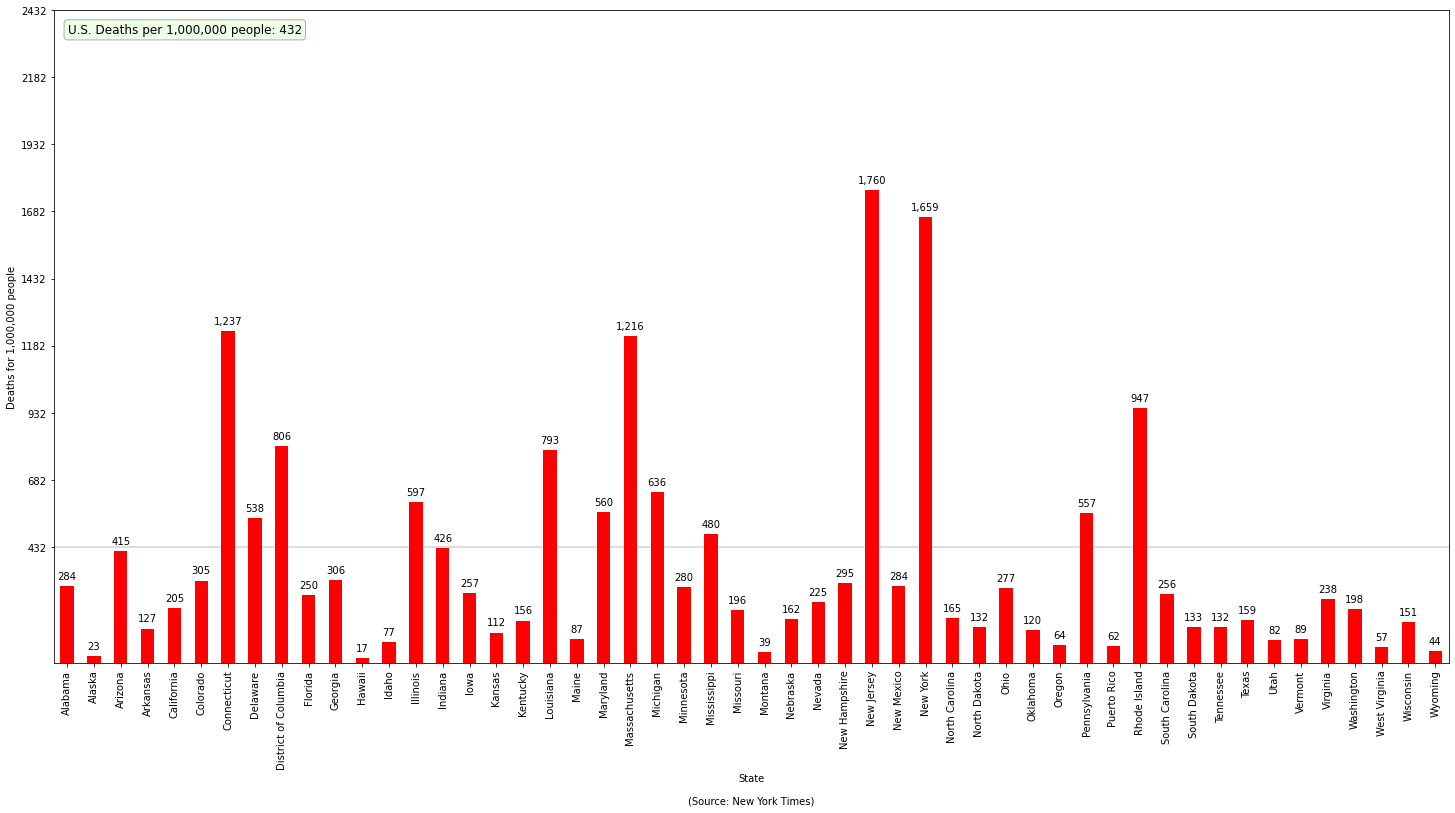

In [42]:
plot_states_per_capita(df_states, SOURCE, populations, image_file='nyt-state-deaths-per-capita.png');

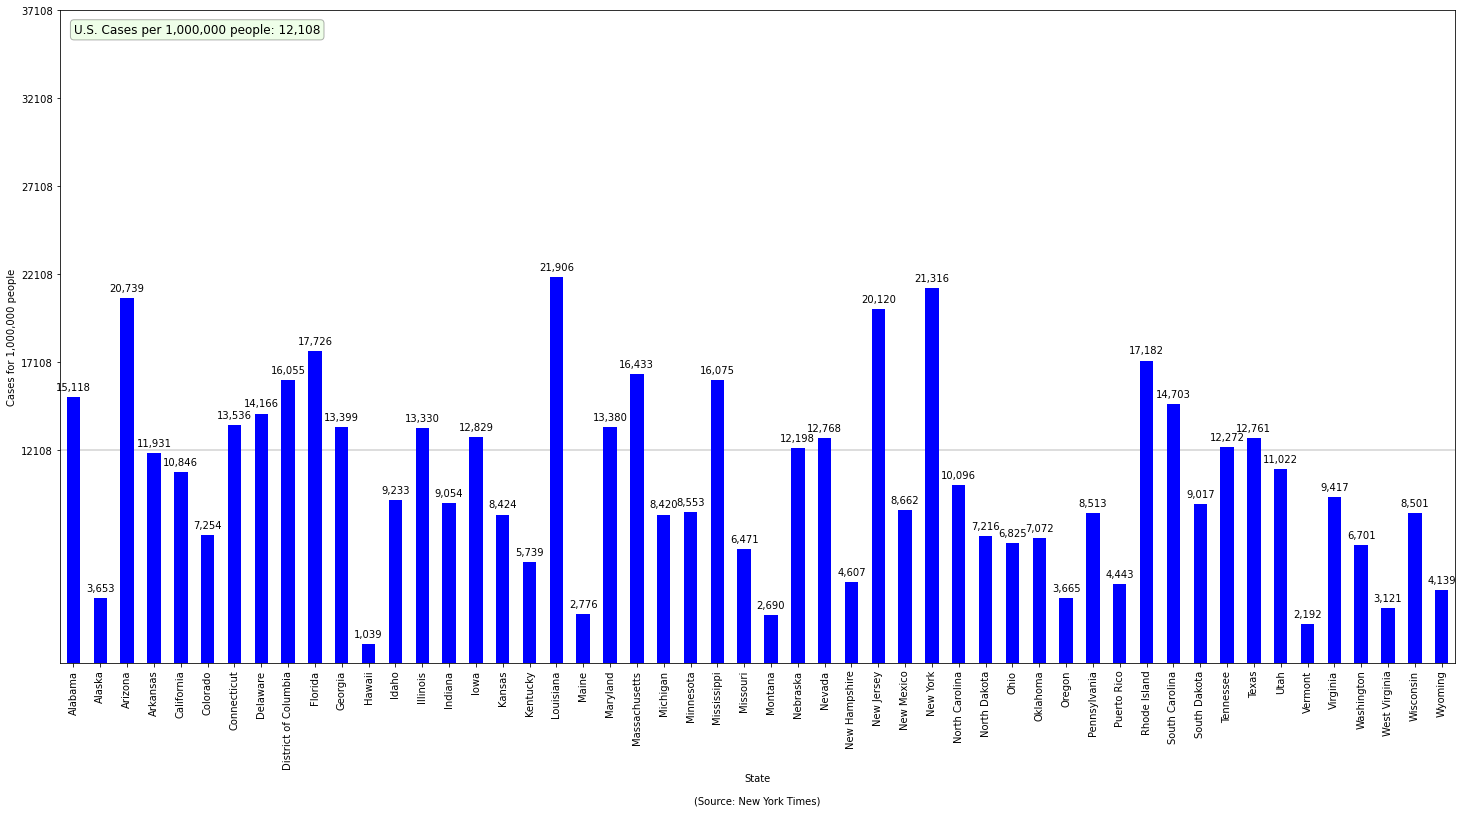

In [43]:
plot_states_per_capita(df_states, SOURCE, populations, metric=MetricType.CASES, image_file='nyt-state-cases-per-capita.png');

## Counties

In [82]:
def plot_counties(df, state, counties, metric=MetricType.DEATHS, image_file=None, 
                  textbox_loc=(0.01, 0.98), textbox_heading=None,
                  figsize=(20, 11), legend_loc='upper center'):
    """
    Plot a set of counties for a particular state. This data is New York Time-specific.
    
    Parameters:
    
    df              - the DataFrame
    state           - The state name
    counties        - The counties within the state (by name)
    metric          - The metric to plot
    image_file      - Where to save the image, if any
    textbox_loc     - (x, y) coordinates of the info textbox
    textbox_heading - A heading to add to the textbox, or None
    figsize         - (width, height) of the plot
    legend_loc      - where to put the legend
    """
    metric_col = METRIC_COLUMNS[metric]
    cases_or_deaths = str(metric.name).capitalize()
    df = df.copy(deep=True)
    df = df.loc[df.county.isin(counties) & (df.state == state)][['month_day', 'county', metric_col]]

    group = df.groupby(['month_day', 'county']).sum()

    # Unstack, to get each county's numbers in a separate column.
    final_df = group.unstack()

    fig, ax = p.subplots(figsize=figsize)

    # Let Pandas plot the whole thing.
    final_df.plot(ax=ax, kind='line', legend=True)

    # Set the X and Y axis labels. Add the credit below the X label,
    # since it's a nice place to stash it without interfering with
    # the plot.
    ax.set_xlabel(f'Week\n\n(Source: {SOURCE})')
    metric_label = METRIC_LABELS[metric]
    ax.set_ylabel(metric_label)

    # Add an explanatory text box.
    text_x, text_y = textbox_loc or (0.01, 0.987)
    heading = f"{state} county {metric_label.lower()}"
    text_lines = [f"{heading}"]
    if textbox_heading:
        text_lines.append(textbox_heading)
    text_lines.append("")
    for county in sorted(counties):
        # Get the last value for the metric. It's the grand total.
        total = round(int(df.loc[df.county == county][metric_col].iloc[-1]))
        text_lines.append(f"{county}: {total:,}")

    textbox(ax, text_x, text_y, '\n'.join(text_lines))
    fix_pandas_multiplot_legend(ax, legend_loc)

    if image_file is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file))


### Some select Pennsylvania counties

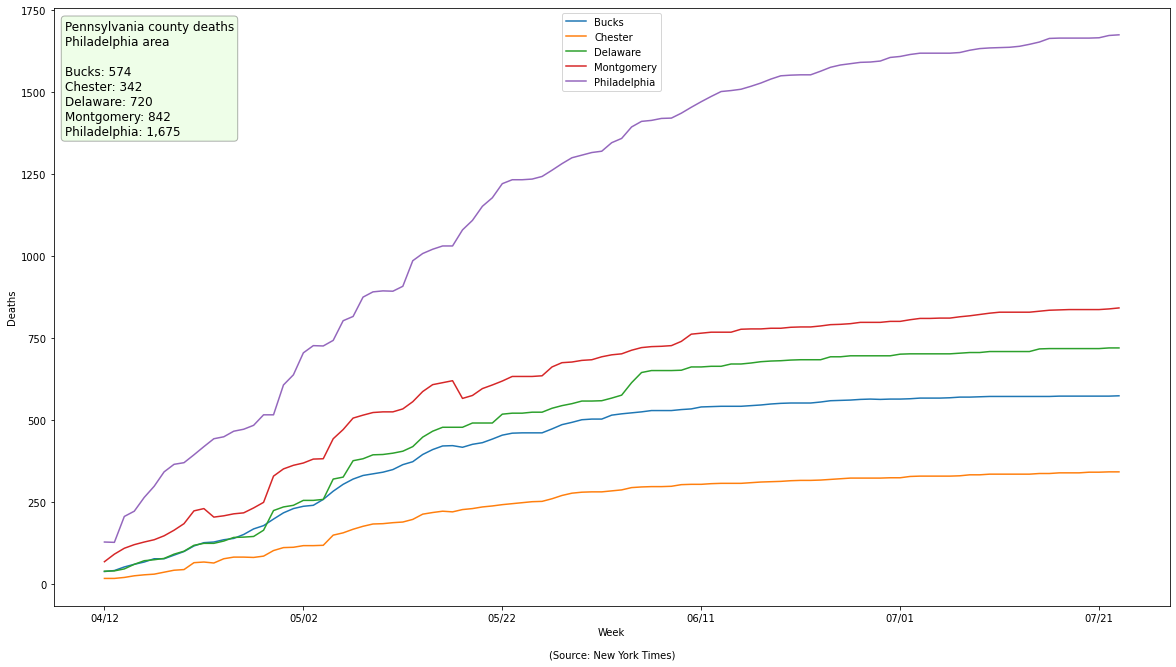

In [83]:
philly_area_counties = ('Montgomery', 'Philadelphia', 'Chester', 'Bucks', 'Delaware')
plot_counties(df_counties, 'Pennsylvania', philly_area_counties, textbox_heading="Philadelphia area",
              metric=MetricType.DEATHS, image_file='nyt-pa-phl-area-deaths.png')

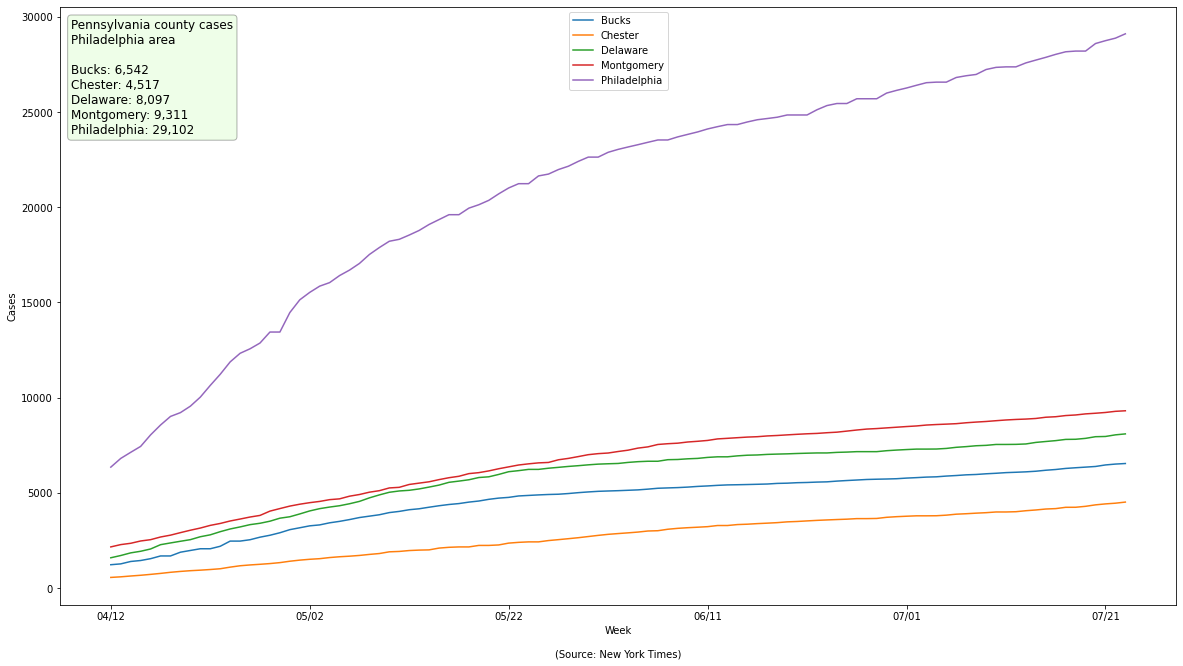

In [84]:
plot_counties(df_counties, 'Pennsylvania', philly_area_counties, textbox_heading="Philadelphia area",
              metric=MetricType.CASES, image_file='nyt-pa-phl-area-cases.png')

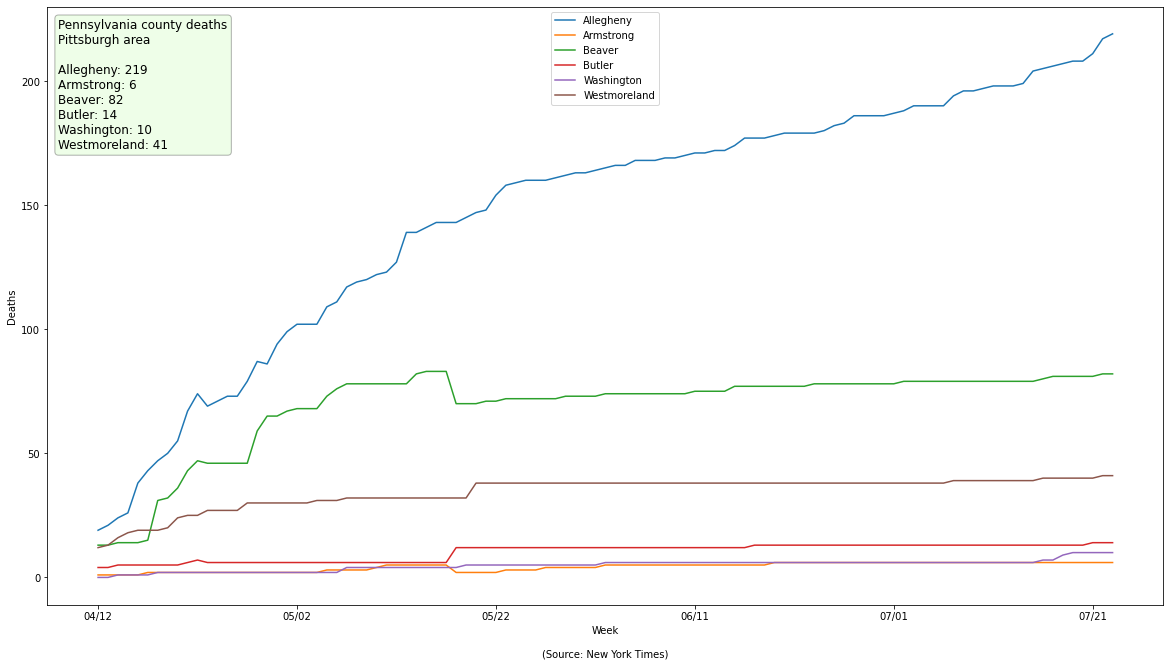

In [85]:
pgh_area_counties = ('Allegheny', 'Butler', 'Beaver',
                     'Washington', 'Westmoreland', 'Armstrong')
plot_counties(df_counties, 'Pennsylvania', pgh_area_counties, textbox_heading="Pittsburgh area",
              metric=MetricType.DEATHS, image_file='nyt-pgh-area-deaths.png')

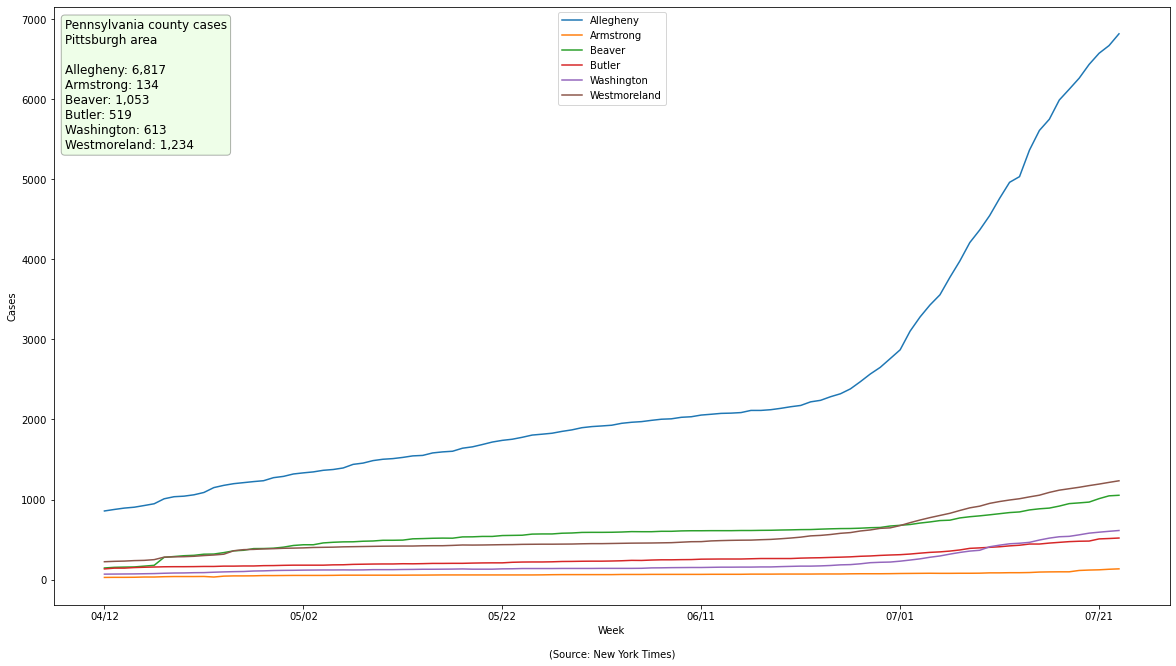

In [86]:
plot_counties(df_counties, 'Pennsylvania', pgh_area_counties, textbox_heading="Pittsburgh area",
              metric=MetricType.CASES, image_file='nyt-pgh-area-cases.png')

## Florida 

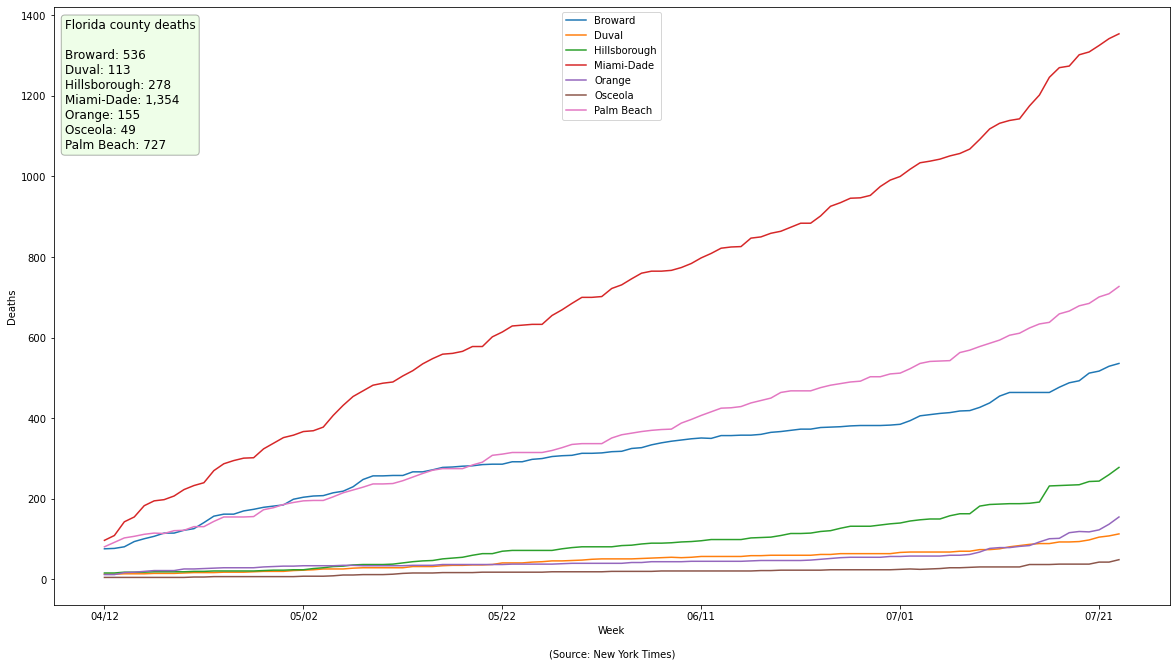

In [87]:
# Osceola and Orange are near Orlando.
# Hillsborough contains Tampa.
# Broward and Palm Beach are near Miami.
# Duval contains Jacksonville.
fl_counties = ('Osceola', 'Orange', 'Miami-Dade', 'Palm Beach',
               'Broward', 'Hillsborough', 'Duval')
plot_counties(df_counties, 'Florida', fl_counties, 
              image_file='nyt-fl-county-deaths.png', metric=MetricType.DEATHS)

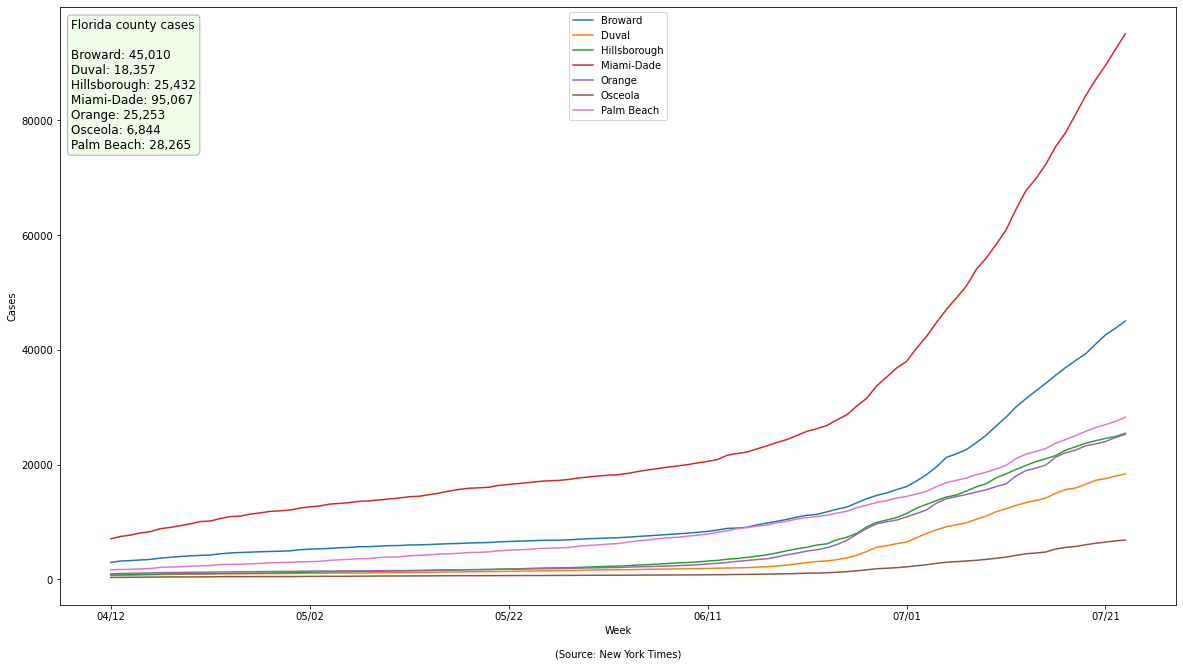

In [88]:
plot_counties(df_counties, 'Florida', fl_counties, 
              image_file='nyt-fl-county-cases.png', metric=MetricType.CASES)